# CNN from scratch

In [ ]:
!pip install keras_tuner

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!unzip '/content/drive/MyDrive/Intelligent System Project/archive.zip' -d "/content"

## Loading and visualizing data

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import keras
import datetime

BASE_DIR = '/content/drive/MyDrive/Intelligent System Project/'
TRAIN_DIR = "archive/asl_alphabet_train/asl_alphabet_train/"
LABELS = list(filter(lambda x: x != ".DS_Store", sorted(os.listdir(TRAIN_DIR))))
LABEL_LIMIT = 3000

IMAGE_SIZE = (64, 64)
IMAGE_DEPTH = (3,)

LOG_DIR = BASE_DIR + "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

We use the following helper function to load the images in a random fashion. The filenames of our dataset follow a sequential order, from 1 to 3000 for each hand sign. We generate a random array seeded with the index of the corresponding label and then we read the files according to the array.



In [3]:
# Helper function
import random
def load_images():

    images = []
    labels = []
    for idx, label in enumerate(LABELS):
        np.random.seed(idx)
        array = np.random.randint(1, 3000, size = LABEL_LIMIT)
        if os.path.isfile(TRAIN_DIR + label): continue
        for val in array:
            filepath = f"{TRAIN_DIR}{label}/{label}{val}.jpg"
            image = cv2.resize(cv2.imread(filepath), IMAGE_SIZE)
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return (images, labels)

images, labels = load_images()

We split our data in order to build a training, a validation and a test dataset.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(LABELS)
train_n = len(X_train)
test_n = len(X_test)
val_n = len(X_val)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)
print("Number of validation images: ", val_n)


Total number of symbols:  29
Number of training images:  69600
Number of testing images:  8700
Number of validation images:  17400


In this section, we visualize the dataset we're working with. For each unique label in our dataset, we have displayed a representative image. This allows us to get an idea of the variety and characteristics of the images in our dataset.

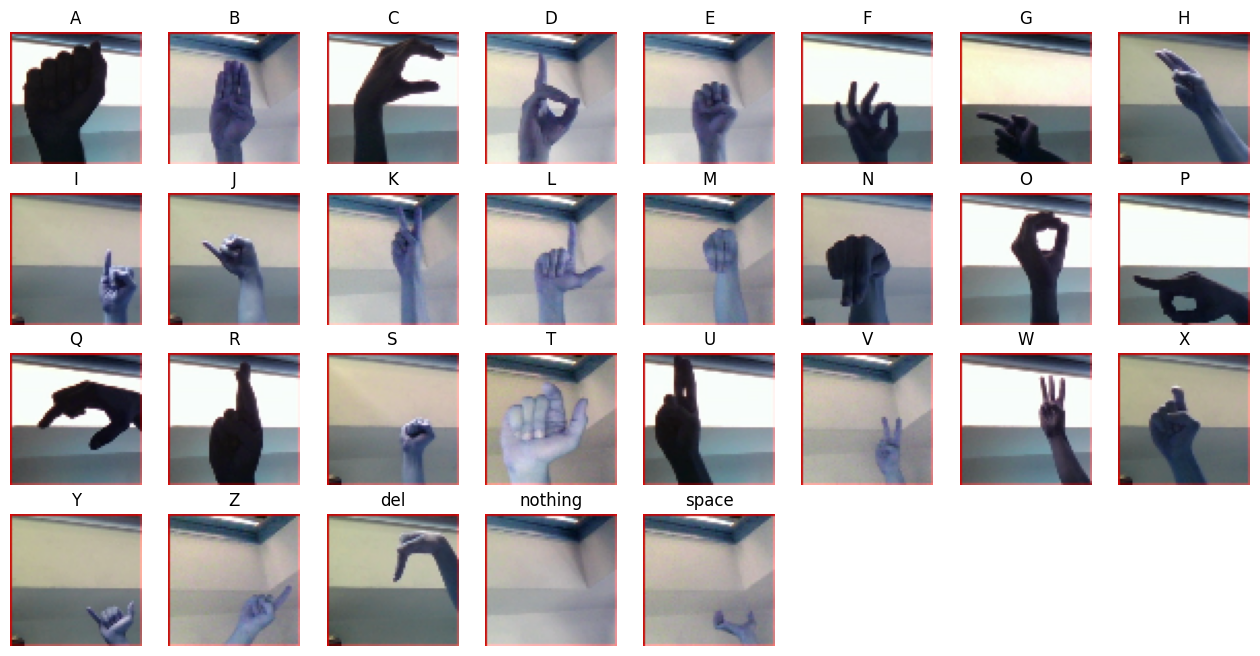

In [ ]:
def plot_one_sample_of_each():
    cols = 8
    rows = int(np.ceil(len(LABELS) / cols))
    fig = plt.figure(figsize=(cols*2, rows*2))

    for i in range(len(LABELS)):
        cls = LABELS[i]
        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i * LABEL_LIMIT])
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

plot_one_sample_of_each()

## Building the model

We start off by building a very simple convolutional neural network. The CNN we start from is made of a first convolutional layer with 16 filters, a Max Pooling layer and a final fully-connected layer.

In [5]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = IMAGE_SIZE + IMAGE_DEPTH))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(len(LABELS), activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 29)                475165    
                                                                 
Total params: 475,613
Trainable params: 475,613
Non-trainable params: 0
_________________________________________________________________


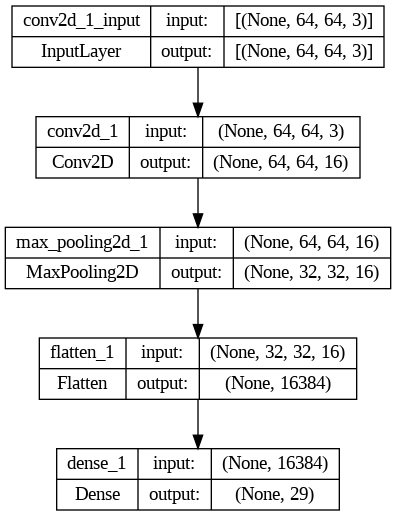

In [ ]:
from keras.utils import plot_model
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
plot_model(model, show_shapes = True)

We train our network for 80 epochs

In [ ]:
history = model.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/80
1088/1088 [==============================] - 6s 5ms/step - loss: 29.1496 - accuracy: 0.6745 - val_loss: 0.4241 - val_accuracy: 0.8721
Epoch 2/80
1088/1088 [==============================] - 6s 5ms/step - loss: 0.3023 - accuracy: 0.9043 - val_loss: 0.3857 - val_accuracy: 0.8917
Epoch 3/80
1088/1088 [==============================] - 5s 4ms/step - loss: 0.1907 - accuracy: 0.9390 - val_loss: 0.4685 - val_accuracy: 0.8739
Epoch 4/80
1088/1088 [==============================] - 5s 4ms/step - loss: 0.1510 - accuracy: 0.9533 - val_loss: 0.2507 - val_accuracy: 0.9364
Epoch 5/80
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1257 - accuracy: 0.9615 - val_loss: 0.2103 - val_accuracy: 0.9521
Epoch 6/80
1088/1088 [==============================] - 5s 4ms/step - loss: 0.1046 - accuracy: 0.9682 - val_loss: 0.1936 - val_accuracy: 0.9626
Epoch 7/80
1088/1088 [==============================] - 4s 4ms/step - loss: 0.0916 - accuracy: 0.9726 - val_loss: 0.1847 - val_accuracy

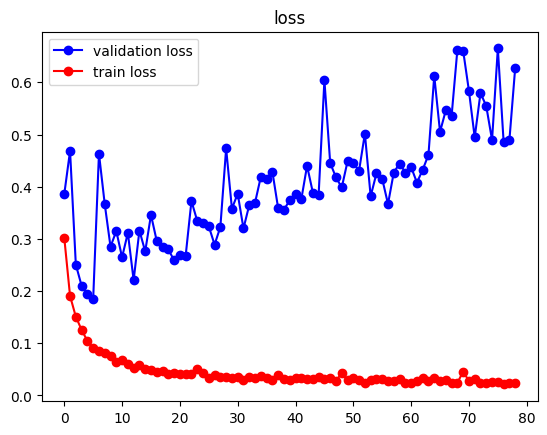

In [ ]:
def plot_loss(history):
  loss = history.history["loss"][1:]
  val_loss = history.history["val_loss"][1:]
  plt.figure()
  plt.plot(val_loss,'o-b', label='validation loss')
  plt.title('val_loss')
  plt.plot(loss,'o-r', label='train loss')
  plt.title('loss')
  plt.legend()
  plt.show()

plot_loss(history)

In [ ]:
model.evaluate(X_test, y_test, return_dict = True)

272/272 [==============================] - 1s 3ms/step - loss: 0.1356 - accuracy: 0.9939


{'loss': 0.13563889265060425, 'accuracy': 0.9939080476760864}

The evaluation of the current network shows some notable signs of overfitting. The validation loss is gradually increasing despite the training loss approaching 0. This means that our network is losing the ability to generalize on unseen data.
In the upcoming sections, we will first increase the network capacity in order to achieve a better accuracy level and secondly we will introduce some techniques to prevent overfitting.

## Increasing the network capacity

In order to improve the performances of our model, we are increasing its capacity by adding two extra convolutional layers. Each of these layers will have an incremented number of filters, thus allowing the model to learn more complex representations. On top of this, we have added an extra fully connected layer.

While we expect a better overall result in terms of accuracy, we also anticipate that this network will still overfit on training data. We will handle this issue later on.

In [ ]:

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = IMAGE_SIZE + IMAGE_DEPTH))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation = 'relu'))
model_1.add(Dense(len(LABELS), activation = 'softmax'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)       

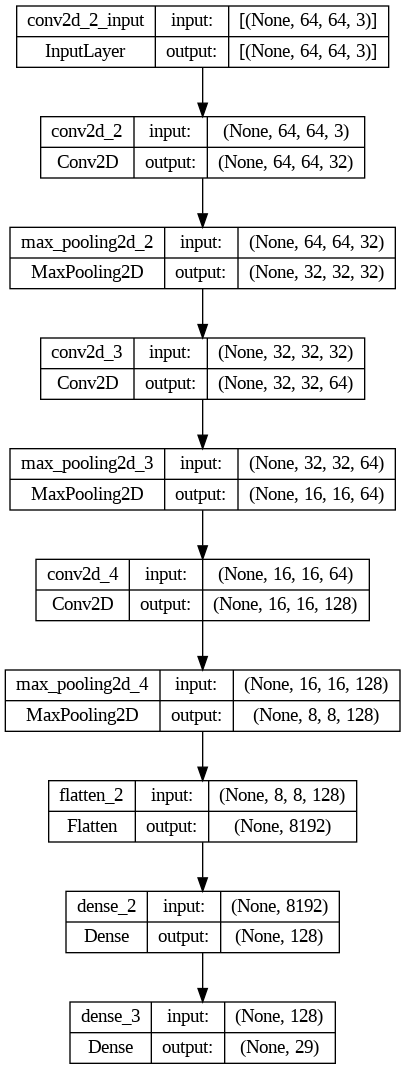

In [ ]:
model_1.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
plot_model(model_1, show_shapes = True)

In [ ]:
history_1 = model_1.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/80
1088/1088 [==============================] - 14s 11ms/step - loss: 1.5448 - accuracy: 0.7670 - val_loss: 0.3072 - val_accuracy: 0.9114
Epoch 2/80
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0935 - accuracy: 0.9743 - val_loss: 0.0541 - val_accuracy: 0.9836
Epoch 3/80
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0696 - accuracy: 0.9840 - val_loss: 0.6720 - val_accuracy: 0.9057
Epoch 4/80
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0658 - accuracy: 0.9880 - val_loss: 0.0468 - val_accuracy: 0.9896
Epoch 5/80
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0638 - accuracy: 0.9892 - val_loss: 0.1660 - val_accuracy: 0.9802
Epoch 6/80
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0589 - accuracy: 0.9909 - val_loss: 0.2601 - val_accuracy: 0.9648
Epoch 7/80
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0650 - accuracy: 0.9914 - val_loss: 0.0532 -

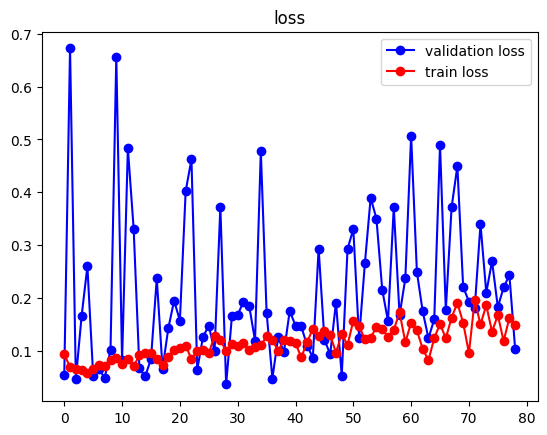

272/272 [==============================] - 1s 4ms/step - loss: 0.0518 - accuracy: 0.9992


{'loss': 0.05176781490445137, 'accuracy': 0.999195396900177}

In [ ]:
plot_loss(history_1)
model_1.evaluate(X_test, y_test, return_dict = True)

As anticipated, the network considerably improved in terms of accuracy but it's still overfitting. This conclusion is drawn by mainly two observations:

*   The graph shows occasional spikes in validation loss, probably meaning that the model is not able to generalize properly
*   The training loss is increasing over time, suggesting that the model is learning patterns that are actually noise or random variations rather than useful features. This is clearly caused by the increase in capacity of the network.




## Handling overfitting

In order to mitigate overfitting, we have adopted the following technqiues:



1.   **Dropout layers**: we are adding a dropout layer after each Convolutional-MaxPooling layer. This will help each neuron to learn without relying on its neighboring neurons
2.   **Early stopping**: we will fit our model using an early stopping callback in order to stop the training if the performance of the network does not improve within X steps
3.   **Learning rate reduction on plateau**: reducing learning rate when we observe lack of significant improvement can help reaching better performance. A high learning rate can hinder the achievement of the optimal solution, thereby lowering the learning rate can help us achieve better convergence.





In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = IMAGE_SIZE + IMAGE_DEPTH))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout(0.3))

model_2.add(Flatten())
model_2.add(Dense(128, activation="relu"))
model_2.add(Dense(len(LABELS), activation = 'softmax'))

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)       

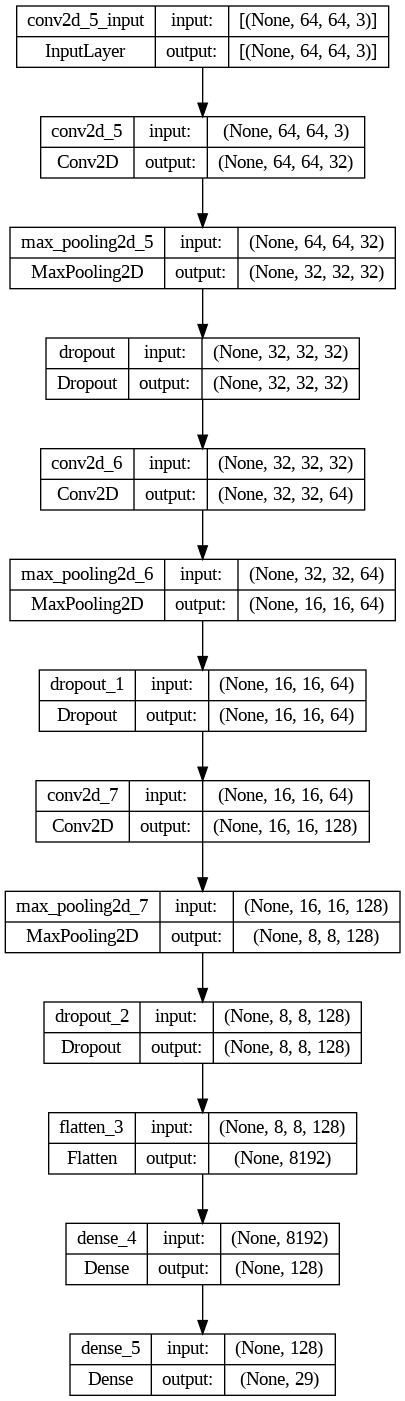

In [ ]:
model_2.compile(optimizer = keras.optimizers.RMSprop(learning_rate=1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
plot_model(model_2, show_shapes = True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=1e-4
)

history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=80,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/80
1088/1088 [==============================] - 16s 14ms/step - loss: 2.8683 - accuracy: 0.4353 - val_loss: 0.5031 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 2/80
1088/1088 [==============================] - 14s 13ms/step - loss: 0.4375 - accuracy: 0.8584 - val_loss: 0.0958 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 3/80
1088/1088 [==============================] - 15s 14ms/step - loss: 0.2659 - accuracy: 0.9209 - val_loss: 0.0719 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 4/80
1088/1088 [==============================] - 14s 13ms/step - loss: 0.2189 - accuracy: 0.9405 - val_loss: 0.0401 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 5/80
1088/1088 [==============================] - 14s 13ms/step - loss: 0.1962 - accuracy: 0.9509 - val_loss: 0.0439 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 6/80
1088/1088 [==============================] - 15s 14ms/step - loss: 0.2076 - accuracy: 0.9540 - val_loss: 0.0920 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 7/80
1088/1088 [========================

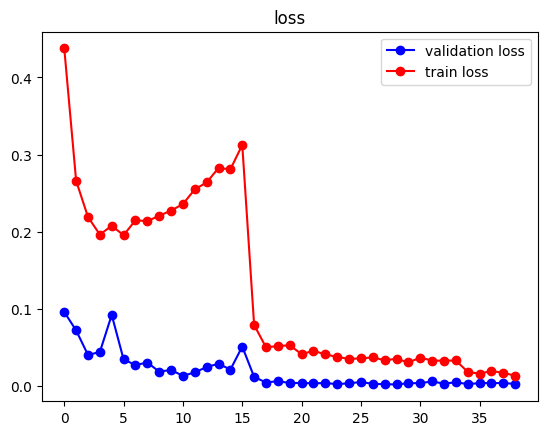

272/272 [==============================] - 1s 5ms/step - loss: 9.3140e-05 - accuracy: 1.0000


{'loss': 9.314011549577117e-05, 'accuracy': 1.0}

In [ ]:
plot_loss(history_2)
model_2.evaluate(X_test, y_test, return_dict = True)

# RGB Normalization and Data augmentation
To enhance the stability of our model's performance and improve its robustness in dealing with unseen data, we have adopted RGB Normalization and Data Augmentation strategies.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)
test_generator = test_datagen.flow(X_test, y_test, batch_size=64)

In [ ]:

model = Sequential()
model.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = IMAGE_SIZE + IMAGE_DEPTH))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(len(LABELS), activation = 'softmax'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 64)       

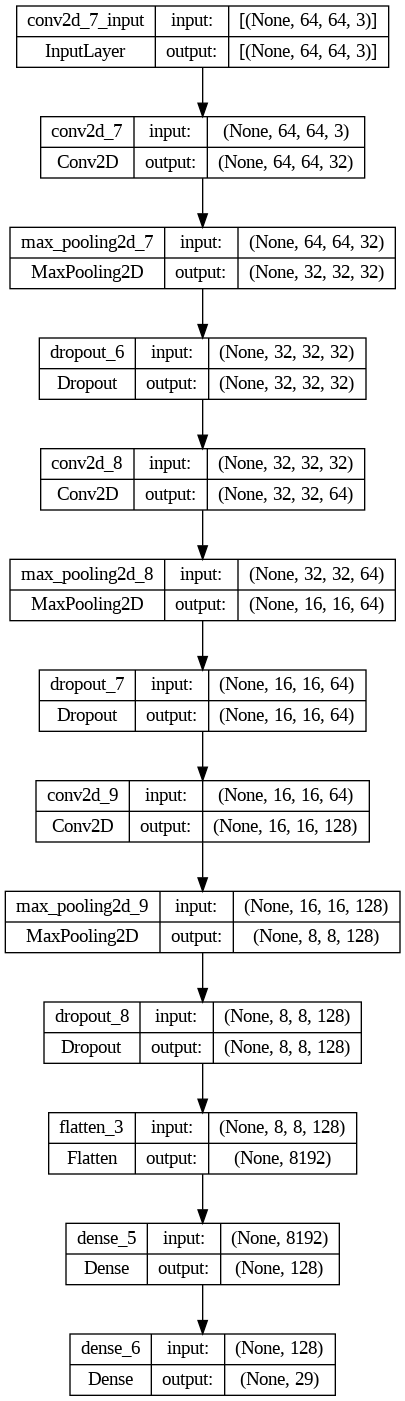

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
plot_model(model, show_shapes = True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=80,
    batch_size=64,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/80
1088/1088 [==============================] - 109s 98ms/step - loss: 1.6776 - accuracy: 0.4952 - val_loss: 0.4354 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 2/80
1088/1088 [==============================] - 106s 98ms/step - loss: 0.4204 - accuracy: 0.8621 - val_loss: 0.1193 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/80
1088/1088 [==============================] - 106s 98ms/step - loss: 0.2209 - accuracy: 0.9259 - val_loss: 0.0788 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 4/80
1088/1088 [==============================] - 107s 98ms/step - loss: 0.1520 - accuracy: 0.9495 - val_loss: 0.0318 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 5/80
1088/1088 [==============================] - 106s 97ms/step - loss: 0.1146 - accuracy: 0.9620 - val_loss: 0.0343 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 6/80
1088/1088 [==============================] - 106s 97ms/step - loss: 0.0970 - accuracy: 0.9683 - val_loss: 0.0174 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 7/80
1088/1088 [==================

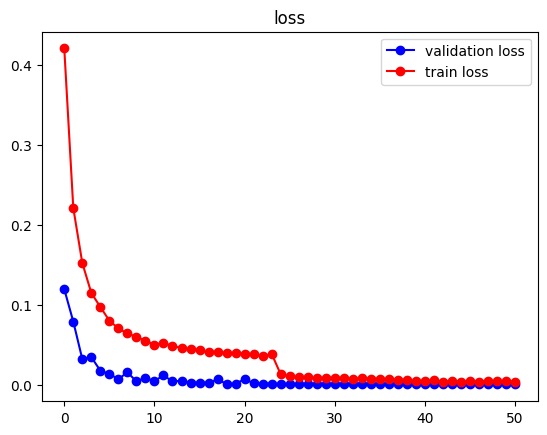

136/136 [==============================] - 1s 7ms/step - loss: 1.3415e-06 - accuracy: 1.0000


{'loss': 1.3415467492450261e-06, 'accuracy': 1.0}

In [ ]:
plot_loss(history)
model.evaluate(test_generator, return_dict = True)

# Hyperparameter tuning

Our next phase of development focuses on finding the best hyperparameters for our model. The hyperparameters under consideration include:


1.   Initial amount of filters
2.   Number of convolutional layers
3.   Kernel size
4.   Initial learning rate
5.   Dropout rate

Since data augmentation on-the-fly is computationally demanding, the search of hyperparameter was made with no data augmentation.

In [6]:

import keras_tuner as kt

def model_builder(hp):

  model = keras.Sequential()
  hp_init_filters = hp.Choice('init_filters', values = [32, 64])

  hp_conv_layers = hp.Int("conv_layers", min_value = 1, max_value = 3, step = 1)

  hp_kernel_size = hp.Choice('kernel_size', values = [3, 5, 7])

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

  for i in range(hp_conv_layers):
    if i == 0:
      model.add(Conv2D(hp_init_filters, kernel_size = hp_kernel_size, padding = 'same', activation = 'relu', input_shape = IMAGE_SIZE + IMAGE_DEPTH))
    else:
      model.add(Conv2D(hp_init_filters  * (2 ** i), kernel_size = hp_kernel_size, padding = 'same', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2,2)))
    hp_dropout = hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.3, step=0.1)
    model.add(Dropout(hp_dropout))


  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(len(LABELS), activation = 'softmax'))

  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                loss= 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=15,
                     factor=3,
                     directory=LOG_DIR,
                     project_name='ASL_KerasTuner')

For this part, we only apply RGB normalization

In [8]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [ ]:
tuner.search(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The hyperparameter search is complete.")

Trial 30 Complete [00h 03m 15s]
val_accuracy: 0.900510847568512

Best val_accuracy So Far: 0.9984674453735352
Total elapsed time: 00h 47m 20s
The hyperparameter search is complete.


After training the model using the best hyperparameters, we store the epoch at which we reached the highest accuracy level.

In [10]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), callbacks=[reduce_lr])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/60
2175/2175 [==============================] - 12s 5ms/step - loss: 1.2634 - accuracy: 0.6251 - val_loss: 0.4064 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 2/60
2175/2175 [==============================] - 10s 5ms/step - loss: 0.2758 - accuracy: 0.9112 - val_loss: 0.1915 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 3/60
2175/2175 [==============================] - 10s 4ms/step - loss: 0.1307 - accuracy: 0.9574 - val_loss: 0.1048 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 4/60
2175/2175 [==============================] - 9s 4ms/step - loss: 0.0797 - accuracy: 0.9744 - val_loss: 0.0603 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 5/60
2175/2175 [==============================] - 10s 4ms/step - loss: 0.0552 - accuracy: 0.9826 - val_loss: 0.0589 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 6/60
2175/2175 [==============================] - 9s 4ms/step - loss: 0.0453 - accuracy: 0.9853 - val_loss: 0.0876 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 7/60
2175/2175 [==============================] 

We retrain the model with optimal hyperparameters limiting the training to the number of epochs that yielded the best results previously.

In [11]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel_history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val, y_val), callbacks=[reduce_lr], batch_size = 64)

Epoch 1/23
1088/1088 [==============================] - 9s 8ms/step - loss: 1.5026 - accuracy: 0.5636 - val_loss: 0.7321 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 2/23
1088/1088 [==============================] - 7s 6ms/step - loss: 0.3764 - accuracy: 0.8841 - val_loss: 0.2252 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 3/23
1088/1088 [==============================] - 7s 6ms/step - loss: 0.1603 - accuracy: 0.9509 - val_loss: 0.1218 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 4/23
1088/1088 [==============================] - 7s 6ms/step - loss: 0.0917 - accuracy: 0.9721 - val_loss: 0.1156 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 5/23
1088/1088 [==============================] - 7s 6ms/step - loss: 0.0600 - accuracy: 0.9808 - val_loss: 0.0467 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 6/23
1088/1088 [==============================] - 6s 6ms/step - loss: 0.0415 - accuracy: 0.9873 - val_loss: 0.0873 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/23
1088/1088 [==============================] - 7s

In [12]:
hypermodel.evaluate(X_test, y_test)

272/272 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.9992


[0.002996991155669093, 0.999195396900177]

In [ ]:
import json
hyperparameters = {
    'init_filters': best_hps.get('init_filters'),
    'conv_layers': best_hps.get('conv_layers'),
    'kernel_size': best_hps.get('kernel_size'),
    'learning_rate': best_hps.get('learning_rate')
}

for i in range(best_hps.get('conv_layers')):
  hyperparameters["dropout_" + str(i)] = best_hps.get('dropout_' + str(i))
print()
with open(f'{BASE_DIR}cnn_best_hp.txt', 'w') as convert_file:
     convert_file.write(json.dumps(hyperparameters, indent = 4))

print(json.dumps(hyperparameters, indent = 4))

{
    "init_filters": 32,
    "conv_layers": 3,
    "kernel_size": 7,
    "learning_rate": 0.001,
    "dropout_0": 0.1,
    "dropout_1": 0.1,
    "dropout_2": 0.1
}


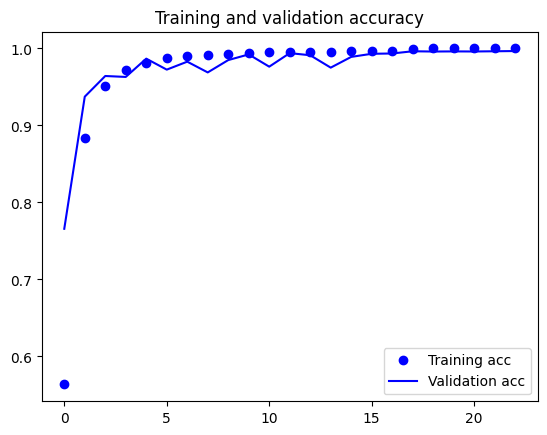

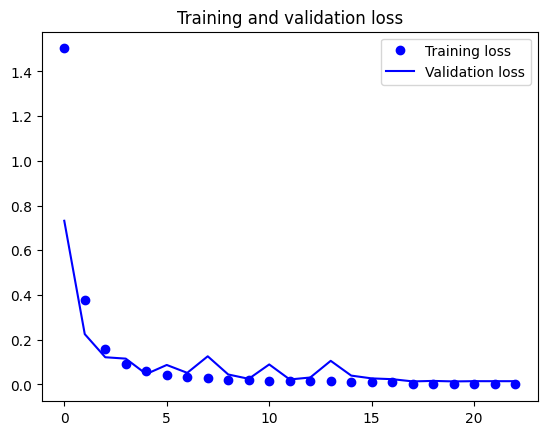

In [13]:
acc = hypermodel_history.history['accuracy']
val_acc = hypermodel_history.history['val_accuracy']
loss = hypermodel_history.history['loss']
val_loss = hypermodel_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These graphs show the progression of the model's performance.

The loss values decrease steadily throughout the epochs, suggesting that the model is actually learning and minimizing errors.

Overall, these results show the model's capability to generalize well on the given dataset, achieving almost perfect accuracy on both training, validation and test sets.

In [ ]:
hypermodel.save(BASE_DIR + 'models/cnn_from_scratch')